# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 35 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,3 months and 12 days !!!
H2O cluster name:,H2O_from_python_patrickh_fc3ux3
H2O cluster total nodes:,1
H2O cluster free memory:,10.58 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Random Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000)
random = ds_.make_random()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in random.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
random[y] = random[y].asfactor()
rtrain, rvalid, _ = random.split_frame([0.4, 0.3], seed = 12345)
print(rtrain.shape)
print(rvalid.shape)

(80049, 17)
(59947, 17)


In [8]:
rtrain_pd = rtrain.as_data_frame()
rvalid_pd = rvalid.as_data_frame()

In [9]:
rtrain_dm = xgb.DMatrix(rtrain_pd[X],
                        rtrain_pd[y])
rvalid_dm = xgb.DMatrix(rvalid_pd[X],
                        rvalid_pd[y])

In [10]:
ave_y = rtrain_pd['target'].mean()
print(ave_y)

0.5012554810178765


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.5,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 18,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.01,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rtrain_dm, 'train'), (rvalid_dm, 'eval')]

random_model = xgb.train(params, 
                         rtrain_dm, 
                         400,
                         evals=watchlist,
                         early_stopping_rounds=50,
                         verbose_eval=True)

[0]	train-auc:0.535466	eval-auc:0.499067
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.54452	eval-auc:0.497296
[2]	train-auc:0.553027	eval-auc:0.497761
[3]	train-auc:0.561051	eval-auc:0.500392
[4]	train-auc:0.569786	eval-auc:0.501116
[5]	train-auc:0.571478	eval-auc:0.50034
[6]	train-auc:0.576353	eval-auc:0.499641
[7]	train-auc:0.580708	eval-auc:0.500343
[8]	train-auc:0.588571	eval-auc:0.500076
[9]	train-auc:0.590005	eval-auc:0.50083
[10]	train-auc:0.592444	eval-auc:0.501285
[11]	train-auc:0.596731	eval-auc:0.501683
[12]	train-auc:0.602872	eval-auc:0.500873
[13]	train-auc:0.605908	eval-auc:0.500947
[14]	train-auc:0.611227	eval-auc:0.500946
[15]	train-auc:0.616366	eval-auc:0.50127
[16]	train-auc:0.621186	eval-auc:0.501354
[17]	train-auc:0.622577	eval-auc:0.501509
[18]	train-auc:0.625427	eval-auc:0.501788
[19]	train-auc:0.627586	eval-auc:0.501774
[20]	train-auc:0.630901	eval-auc:

# Global Variable Importance 

***

#### XGBoost variable importance

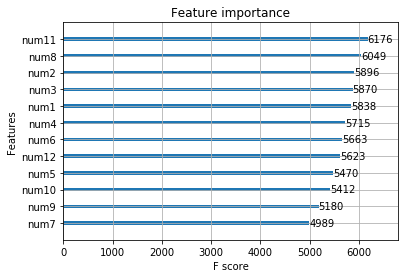

In [12]:
_ = plot_importance(random_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(random_model)

Weight,Feature
0.0847,num9
0.0843,num11
0.0843,num4
0.0841,num7
0.0836,num10
0.0835,num5
0.0831,num6
0.0830,num2
0.0830,num3
0.0830,num12


#### Shapley variable importance

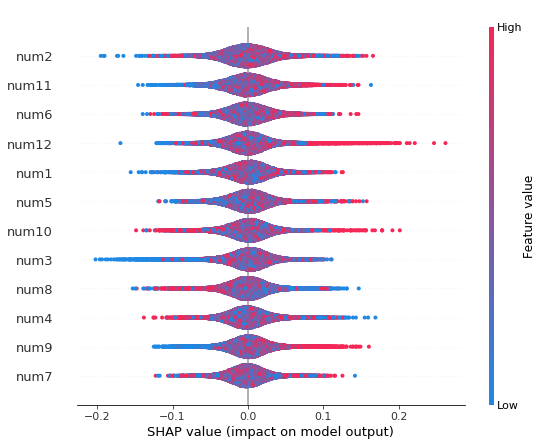

In [14]:
shap_values = random_model.predict(rvalid_dm, pred_contribs=True)
shap.summary_plot(shap_values, rvalid_pd[X])

#### Example Shapley dependence (you can try other variables)

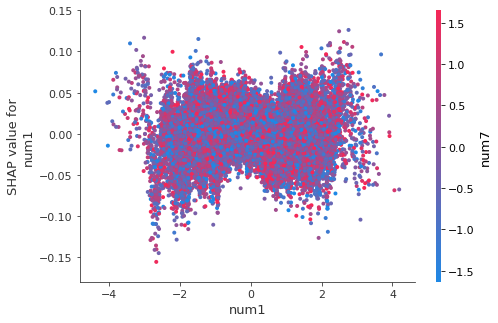

In [15]:
var = "num1" 
shap.dependence_plot(var, shap_values, rvalid_pd[X])

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Bind XGBoost predictions to training data

In [16]:
random_preds = pd.DataFrame(random_model.predict(rvalid_dm))

In [17]:
random_decile_frame = pd.concat([rvalid_pd, random_preds], axis=1)
random_decile_frame = random_decile_frame.rename(columns={0: 'predict'})
random_decile_hframe = h2o.H2OFrame(random_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
random_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,0.471918
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,0.500790
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,0.474551
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,0.495823
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,0,10,0.460597


#### Find percentiles of XGBoost predictions

In [19]:
random_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', random_decile_hframe)

In [20]:
random_percentile_dict

{0: 34868,
 10: 58156,
 20: 7722,
 30: 2084,
 40: 91463,
 50: 169947,
 60: 133437,
 70: 43365,
 80: 147440,
 90: 72286,
 99: 68395}

# Explanation at each decile

#### Utility function that displays the TreeInterpreter results at the chosen decile 

In [21]:
def eli5_dd(decile):
    row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(random_model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(random_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [22]:
explainer = LIMEExplainer(training_frame=rvalid_pd, X=X, model=random_model, discretize=None)

def lime(decile):
    row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displayes the Shapley results at the chosen decile

In [23]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [24]:
decile = 10
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num3                         -0.134873
num12                        -0.017771
num4                         -0.015488
num6                         -0.010684
num8                         -0.010456
num11                        -0.008395
num9                         -0.004636
num10                        -0.001315
num2                          0.000440
num1                          0.005614
num7                          0.015273
num5                          0.020694 

Shapley sum:  -0.15409629
Model prediction:  -0.15409658730549192


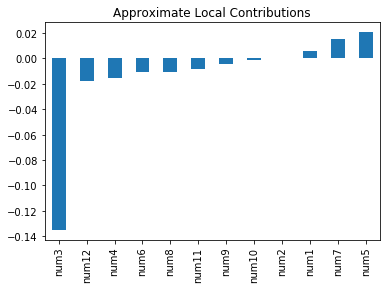

In [25]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7faa82d8ec18>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num7', weight=0.050899622258450905, std=None, value=-1.1797258150395715), FeatureWeight(feature='num8', weight=0.02058268283130926, std=None, value=-0.6795578116169879), FeatureWeight(feature='num6', weight=0.019275605420314833, std=None, value=0.5222305873943809), FeatureWeight(feature='<BIAS>', weight=0.0024785083961645195, std=None, value=1.0)], neg=[FeatureWeight(feature='num3', weight=-0.092512559921946, std=None, value=-2.408120161173479), FeatureWeight(feature='num2', weight=-0.0498738421372903, std=None, value=0.05261027051625167), FeatureWeight(feature='num12', weight=-0.03416432789173531, std=None, value=0.4528102538058728), FeatureWeight(feature='num10', weight=-0.02728284739285265, std=None, value=0.17150856069685005), FeatureWeight(feature='num11', weight=-0.022049702220734248, std=None, value=-1.0805628225837591), FeatureWeight(feature='num5', weight=-0.01688615747202756, std=None, value=-0.5578278152807942), FeatureWeight(feature='num4', weight=-0.005058055725168491, std=None, value=0.603793812726167), FeatureWeight(feature='num9', weight=-0.0028230340803961675, std=None, value=-0.7148571300156646), FeatureWeight(feature='num1', weight=-0.0017044368640887517, std=None, value=-0.34854014788656595)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.1591185447999999, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

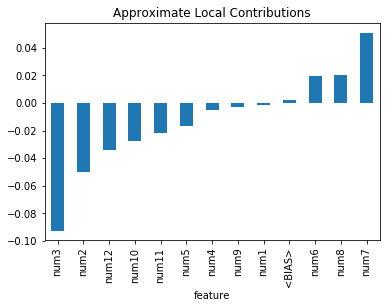

In [26]:
eli5_dd(decile)

In [27]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -0.15409658730549192


### LIME


Model Prediction: 0.46
Local GLM Prediction: 0.48
Local GLM R-square: 0.30
Local GLM Intercept: 0.49

Approximate Local Contributions:
   Input  Local Contribution
0   num1       -5.954458e-03
1   num3       -1.065449e-03
2   num5       -1.564458e-10
3   num7       -1.267172e-13
4   num8       -1.434628e-15
5   num9       -2.432777e-17
6  num11       -7.412715e-18
7   num6        2.858882e-12
8   num4        2.640229e-05
9   num2        1.983537e-04
None


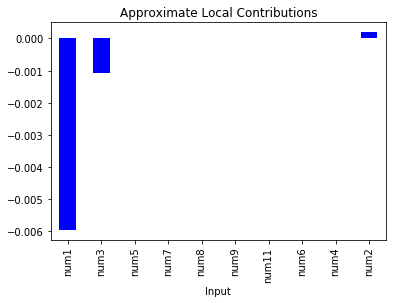

In [28]:
lime(decile)

##  Median of predictions

In [29]:
decile = 50
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num3                         -0.030386
num7                         -0.028035
num5                         -0.024358
num12                        -0.006305
num6                         -0.005451
num10                        -0.004068
num1                         -0.002989
num11                         0.003265
num9                          0.011436
num8                          0.016307
num4                          0.022326
num2                          0.048216 

Shapley sum:  0.007458045
Model prediction:  0.0074577677198011325


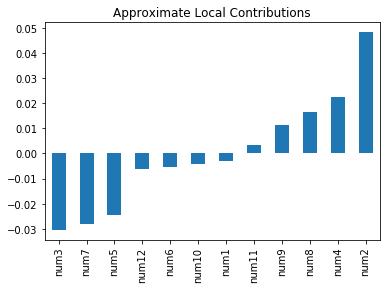

In [30]:
shapley(row)

### TreeInterpreter 

Explanation(estimator='<xgboost.core.Booster object at 0x7faa82d8ec18>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num2', weight=0.05835000960047233, std=None, value=0.4233995602916179), FeatureWeight(feature='num1', weight=0.026377858565419722, std=None, value=-0.0572218000852981), FeatureWeight(feature='num11', weight=0.018827452924453057, std=None, value=-0.21189549873403532), FeatureWeight(feature='num8', weight=0.016272807949626347, std=None, value=-0.18377404925779134), FeatureWeight(feature='num4', weight=0.01367424512147109, std=None, value=-1.6882615980896034), FeatureWeight(feature='<BIAS>', weight=0.0024785083961645195, std=None, value=1.0)], neg=[FeatureWeight(feature='num10', weight=-0.038985741790714463, std=None, value=0.6345262933645954), FeatureWeight(feature='num6', weight=-0.028927384218766495, std=None, value=-1.2858388088290729), FeatureWeight(feature='num3', weight=-0.023261267712252388, std=None, value=-1.362222694602903), FeatureWeight(feature='num12', weight=-0.022379034415580527, std=None, value=0.21217583266303372), FeatureWeight(feature='num5', weight=-0.015830335838675318, std=None, value=-0.062365634985276086), FeatureWeight(feature='num9', weight=-0.0029379334641839467, std=None, value=1.3646758936023018), FeatureWeight(feature='num7', weight=-0.001223042517433898, std=None, value=0.769501396233219)], pos_remaining=0, neg_remaining=0), proba=None, score=0.0024361426000000276, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

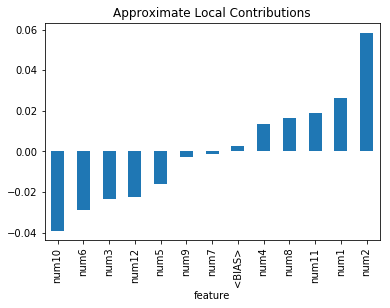

In [31]:
eli5_dd(decile)

In [32]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.0074577677198011325


### LIME


Model Prediction: 0.50
Local GLM Prediction: 0.51
Local GLM R-square: 0.07
Local GLM Intercept: 0.51

Approximate Local Contributions:
  Input  Local Contribution
0  num1       -4.746100e-04
1  num3       -2.957221e-05
2  num4       -8.671356e-10
3  num5       -2.737019e-13
4  num6       -4.796315e-14
5  num8       -2.214835e-18
6  num7        2.411252e-16
7  num2        2.508948e-04
None


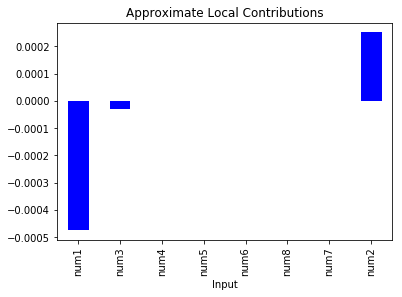

In [33]:
lime(decile)

##  90th decile of model predictions

In [34]:
decile = 90
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num7                         -0.029583
num5                         -0.011806
num12                        -0.005786
num1                         -0.004182
num4                          0.002340
num3                          0.002490
num9                          0.015018
num8                          0.018888
num6                          0.024857
num10                         0.034684
num11                         0.054179
num2                          0.062163 

Shapley sum:  0.1707626
Model prediction:  0.17076262764829642


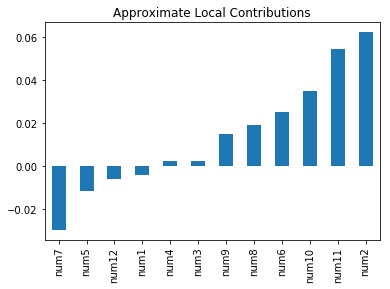

In [35]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7faa82d8ec18>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num2', weight=0.07012497664177501, std=None, value=-2.2635125743962607), FeatureWeight(feature='num11', weight=0.04636603702355229, std=None, value=1.4588554681712602), FeatureWeight(feature='num3', weight=0.045013551479984794, std=None, value=-0.14365734878464526), FeatureWeight(feature='num8', weight=0.024771073754352623, std=None, value=0.6972477232949149), FeatureWeight(feature='num1', weight=0.01523510519829769, std=None, value=0.7287514564329708), FeatureWeight(feature='num6', weight=0.009885511725427783, std=None, value=1.4689772450840466), FeatureWeight(feature='<BIAS>', weight=0.0024785083961645195, std=None, value=1.0), FeatureWeight(feature='num9', weight=0.0016108967600781017, std=None, value=-0.5765026543811111)], neg=[FeatureWeight(feature='num5', weight=-0.02001538064566756, std=None, value=-0.31036275219528003), FeatureWeight(feature='num10', weight=-0.0178367876705009, std=None, value=-0.6073118554490511), FeatureWeight(feature='num7', weight=-0.005727911968627793, std=None, value=0.3801433126562771), FeatureWeight(feature='num12', weight=-0.004600593022012988, std=None, value=-1.0965451693646988), FeatureWeight(feature='num4', weight=-0.0015643615728234447, std=None, value=0.1230252298552604)], pos_remaining=0, neg_remaining=0), proba=None, score=0.1657406261, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

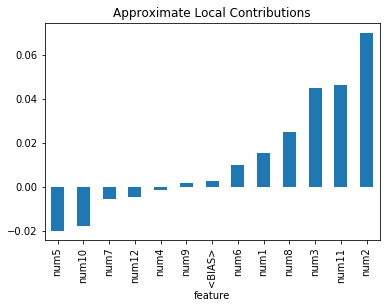

In [36]:
eli5_dd(decile)

In [37]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.17076262764829642


### LIME


Model Prediction: 0.54
Local GLM Prediction: 0.50
Local GLM R-square: 0.14
Local GLM Intercept: 0.50

Approximate Local Contributions:
   Input  Local Contribution
0   num2       -3.906393e-03
1   num3       -3.189072e-06
2   num5       -1.366264e-11
3  num11        1.006966e-17
4   num8        8.121994e-17
5   num7        3.056748e-15
6   num6        8.715801e-13
7   num4        3.996766e-10
8   num1        9.249592e-03
None


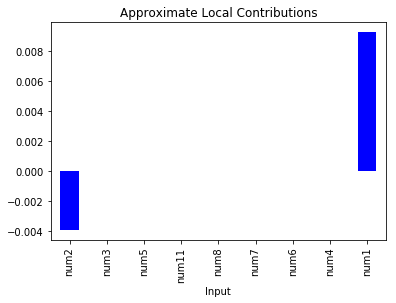

In [38]:
lime(decile)